# Astrostatistics Homework 1
Meredith Durbin

### Contents:
* [Proper Motion Hess Diagrams](#Hess)
* [Other Plots](#Other)
    - [EXPMAG vs. PSFMAG](#mag)
    - [Proper motion distributions](#pm)
    - [Color-color diagrams](#color)
    - [Reddening map](#reddening)

In [1]:
# setup + imports

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import dask.dataframe as dd
import glob
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import vaex
import warnings
from scipy.stats import binned_statistic_2d, iqr

warnings.filterwarnings('ignore') # suppress annoying deprecation warnings
sns.set(style='white', font_scale=1.2)

In [2]:
# select for only objects that have nonzero GRI photometry
query_str = '(G_MEAN_EXPMAG > 0) & (R_MEAN_EXPMAG > 0) & (I_MEAN_EXPMAG > 0)'

# read in files and split into separate dataframes for stars + galaxies
def read_df(hdffile, cols=['G_I_COLOR','R_MEAN_EXPMAG','RA_PM','DEC_PM']):
    df = dd.read_hdf(hdffile, key='data').query(query_str).compute()
    df = df.assign(G_I_COLOR=df.G_MEAN_EXPMAG - df.I_MEAN_EXPMAG)
    df_stars = df.query('MEAN_OBJECT_TYPE > 5')[cols]
    df_galaxies = df.query('MEAN_OBJECT_TYPE <= 5')[cols]
    return df_stars, df_galaxies

In [3]:
def make_histograms(df_all, extent=np.array([[-1.5,4.5],[11,23]])):
    # trim dataframe because honestly I don't wanna look at outliers
    df = df_all[(df_all.G_I_COLOR > extent[0][0]) &
                (df_all.G_I_COLOR < extent[0][1]) & 
                (df_all.R_MEAN_EXPMAG > extent[1][0]) &
                (df_all.R_MEAN_EXPMAG < extent[1][1])]
    
    # compute Hess diagram and PM-shaded histograms
    xwidth = 2*0.7413*iqr(df.G_I_COLOR)/df.shape[0]**(1/3)
    ywidth = 2*0.7413*iqr(df.R_MEAN_EXPMAG)/df.shape[0]**(1/3)
    xbins = np.arange(extent[0][0], extent[0][1]+xwidth, xwidth)
    ybins = np.arange(extent[1][0], extent[1][1]+ywidth, ywidth)
    h1, xedges, yedges = np.histogram2d(df.G_I_COLOR, df.R_MEAN_EXPMAG,
                                        bins=[xbins, ybins], range=extent)
    ra_pm = binned_statistic_2d(df.G_I_COLOR, df.R_MEAN_EXPMAG, df.RA_PM,
                                statistic='median', bins=[xbins, ybins], range=extent)[0]
    dec_pm = binned_statistic_2d(df.G_I_COLOR, df.R_MEAN_EXPMAG, df.DEC_PM,
                                 statistic='median', bins=[xbins, ybins], range=extent)[0]
    # set nan values in h1 for consistency
    h1[~np.isfinite(ra_pm)] = np.nan
    
    # set up figure
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4), sharex=True, sharey=True)
    ax1.set_xlim(extent[0])
    ax1.set_ylim(extent[1])
    ax1.invert_yaxis() 
    
    # show histograms
    ax1.imshow(h1.T[::-1], extent=extent.ravel(),
               cmap=plt.cm.viridis, aspect=0.5)
    ax2.imshow(ra_pm.T[::-1], extent=extent.ravel(),
               cmap=plt.cm.Spectral, aspect=0.5, vmin=-0.02, vmax=0.02)
    im = ax3.imshow(dec_pm.T[::-1], extent=extent.ravel(),
                    cmap=plt.cm.Spectral, aspect=0.5, vmin=-0.02, vmax=0.02)
    # add colobar
    pos = ax3.get_position()
    cax = fig.add_axes([pos.x1+0.02,pos.y0,0.015,pos.height])
    cbar = fig.colorbar(im, cax=cax, label='Proper motion')
    
    # add contours on PM plots
    # downsample dataframe by 10 because this is slow as hell
    samp = df.sample(int(df.shape[0]/10))
    sns.kdeplot(samp.G_I_COLOR, samp.R_MEAN_EXPMAG, ax=ax2)
    sns.kdeplot(samp.G_I_COLOR, samp.R_MEAN_EXPMAG, ax=ax3)
    
    # add labels
    for ax in (ax1, ax2, ax3):
        ax.set_xlabel('G - I')
    ax1.set_ylabel('R (mean expmag)')
    ax1.text(4, 11, 'Hess diagram', ha='right')
    ax2.text(4, 11, 'RA PM', ha='right')
    ax3.text(4, 11, 'Dec PM', ha='right')
    return fig, (ax1, ax2, ax3)

## Proper Motion Hess Diagrams <a id='Hess'></a>

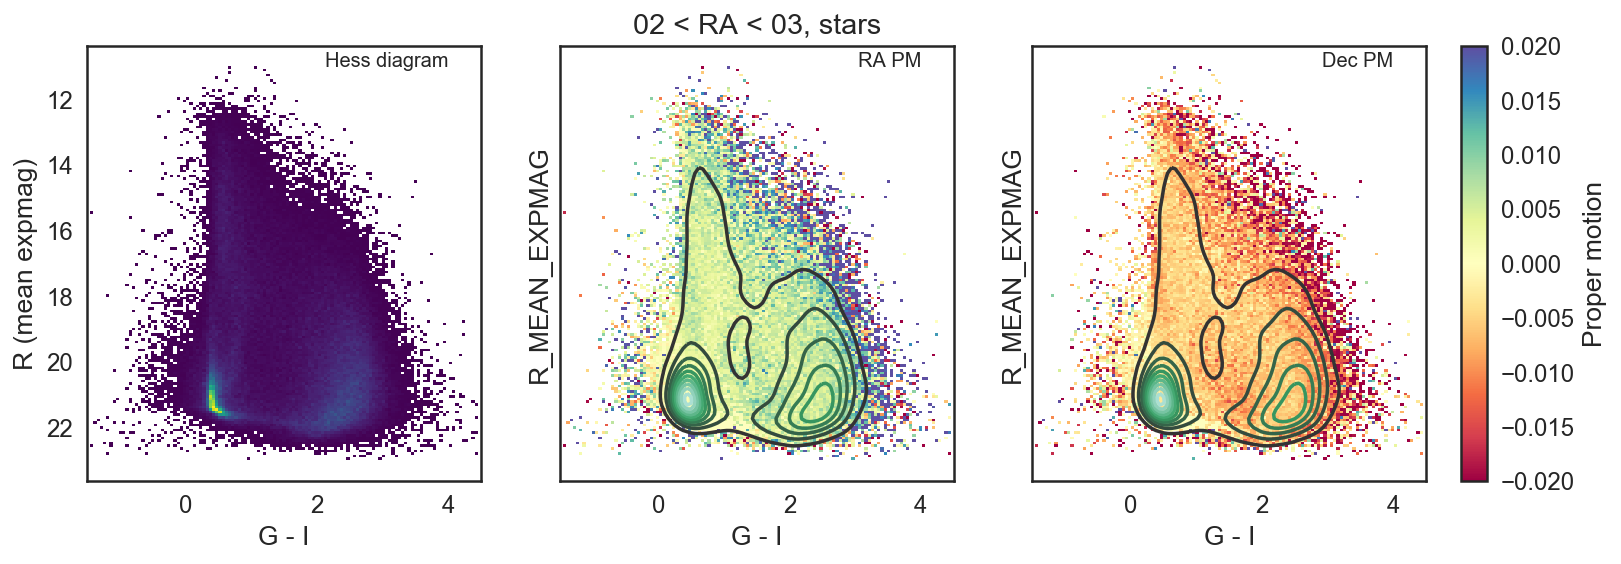

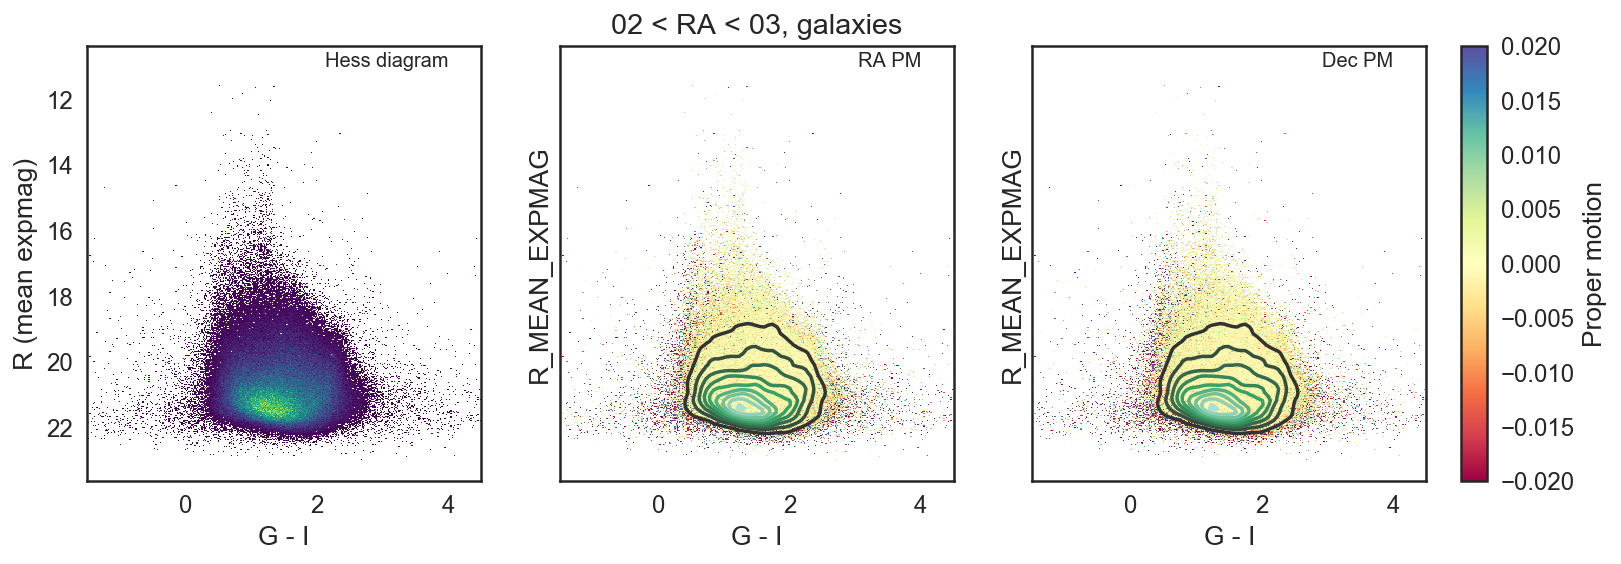

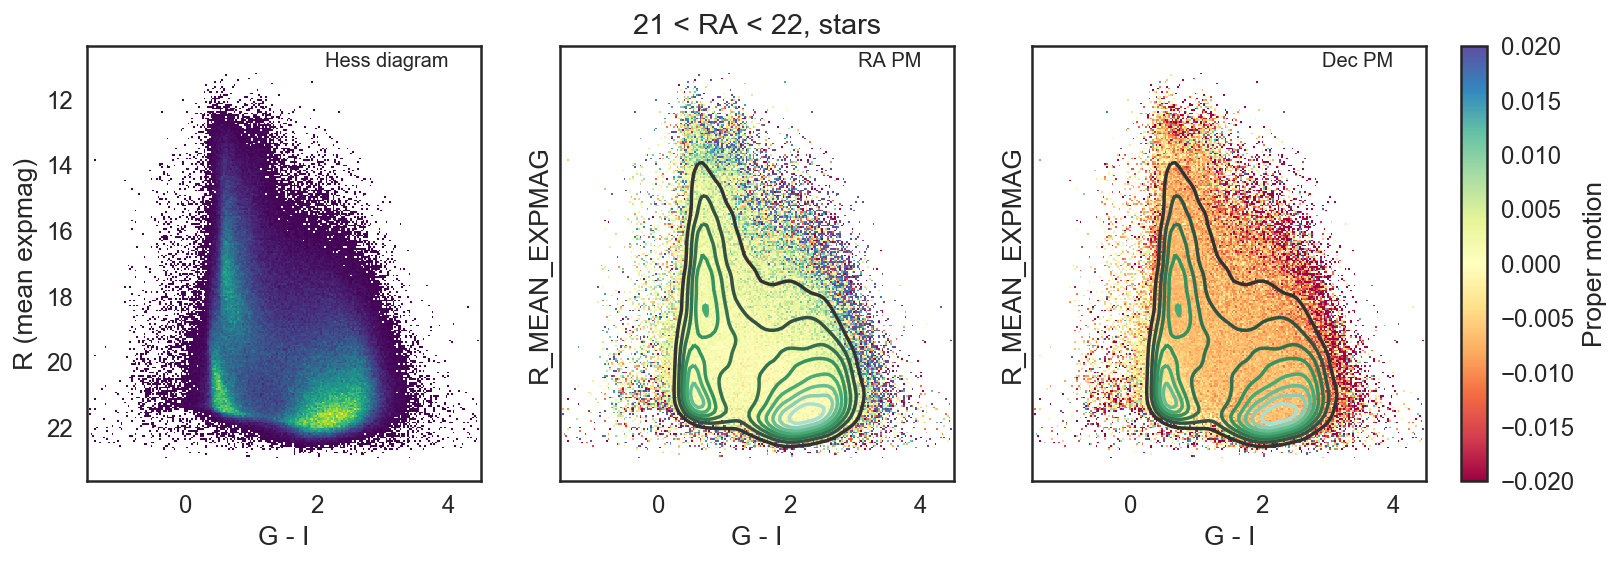

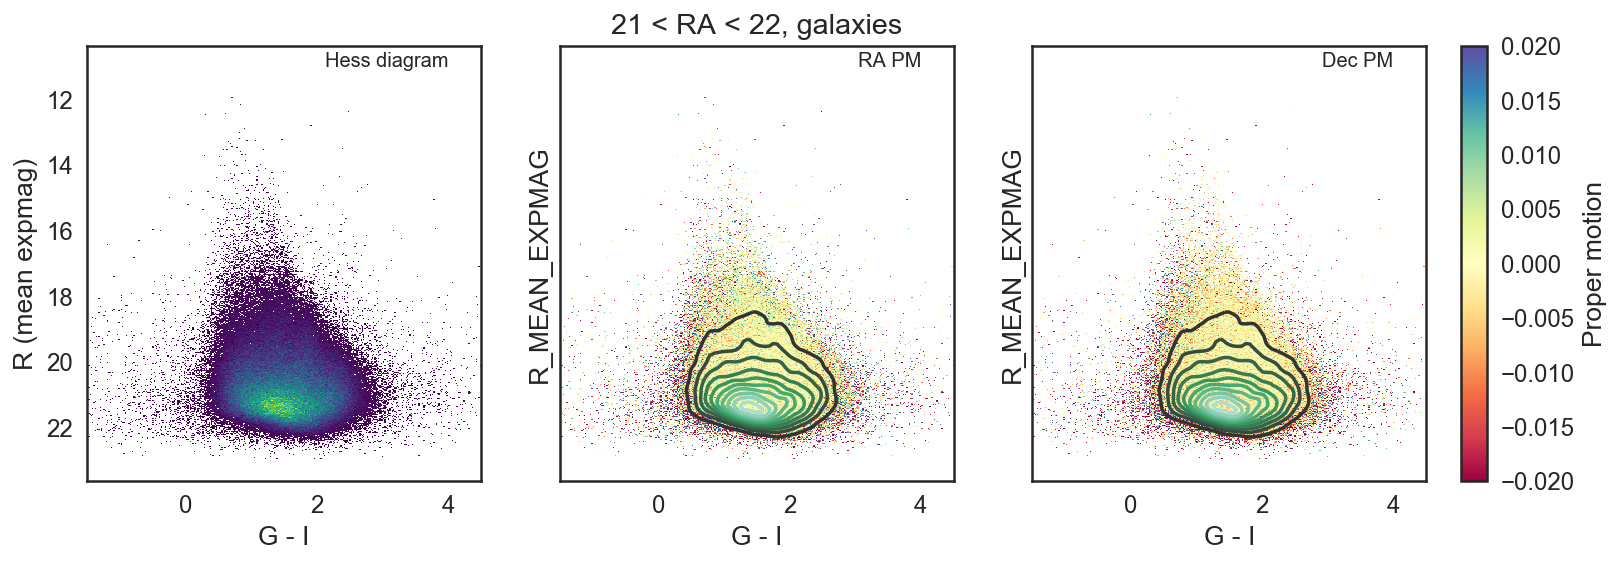

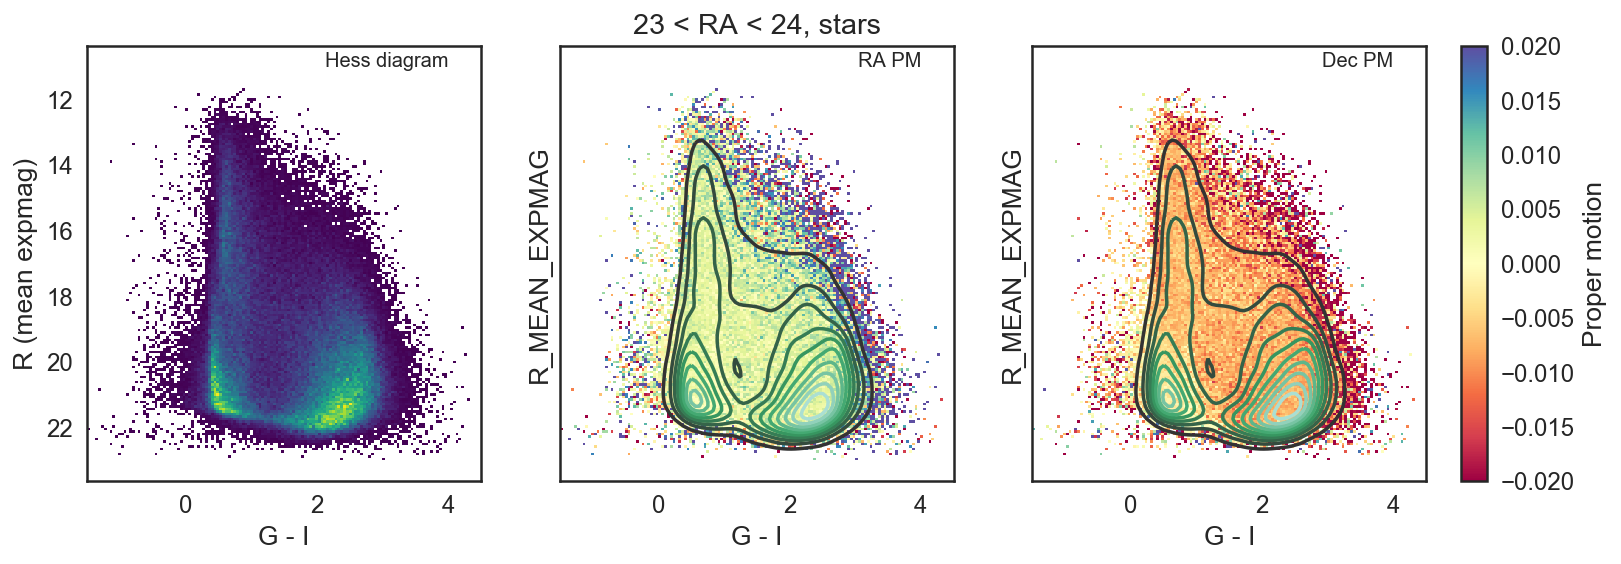

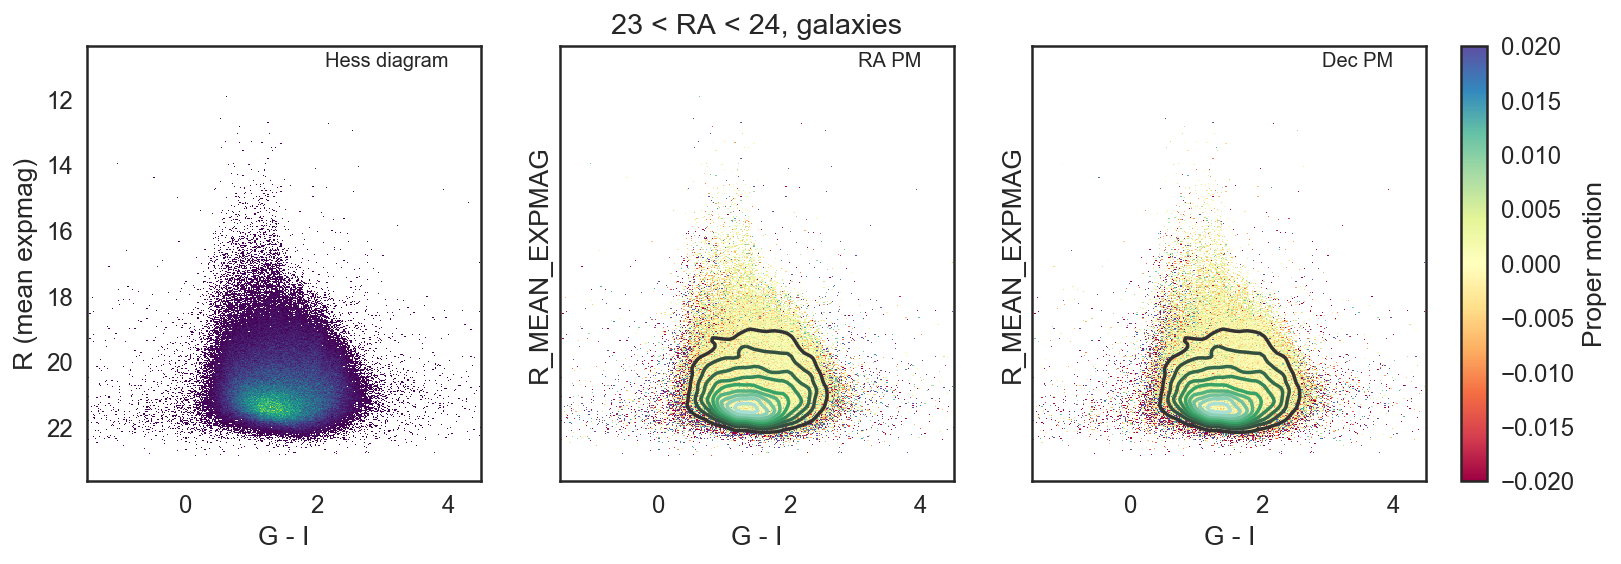

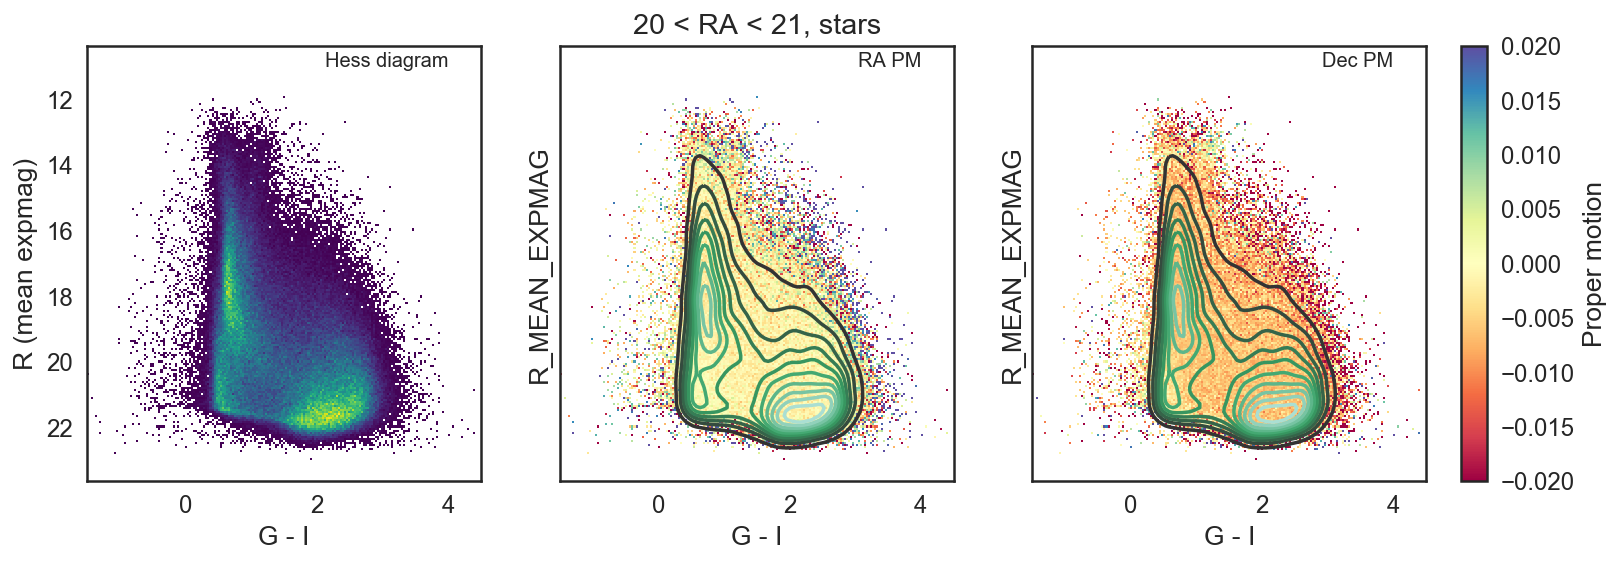

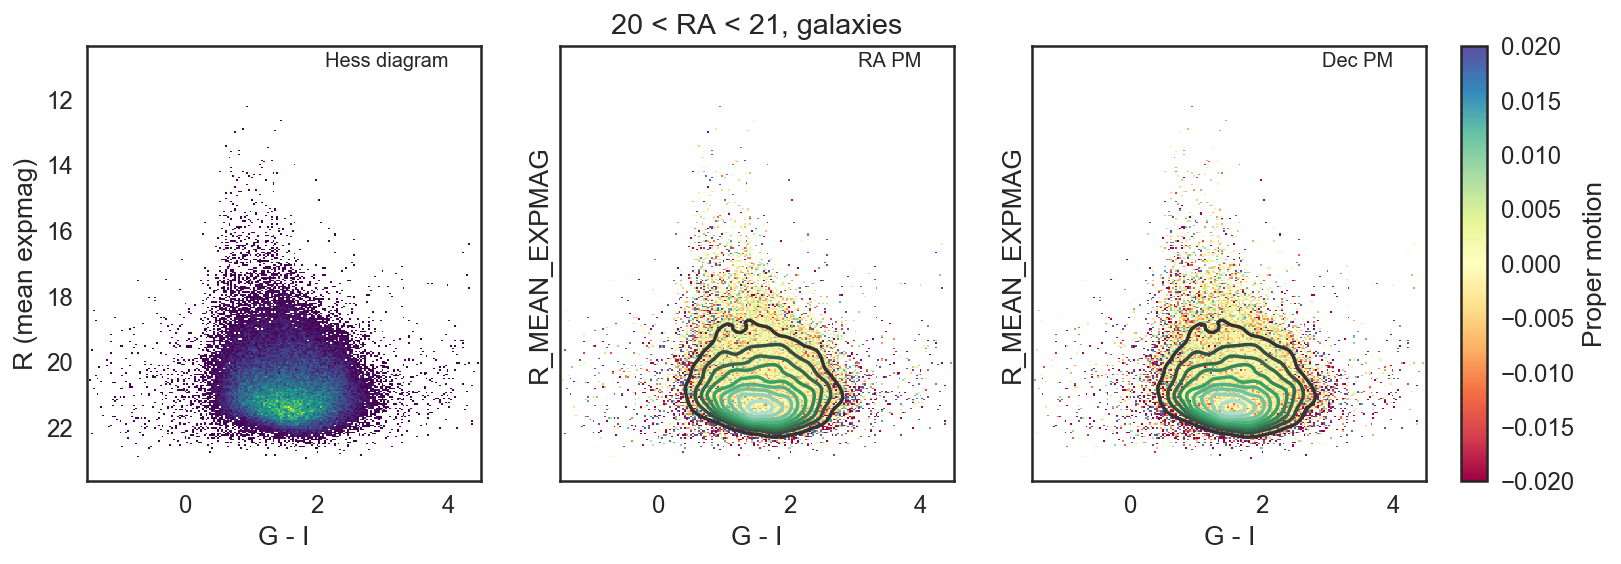

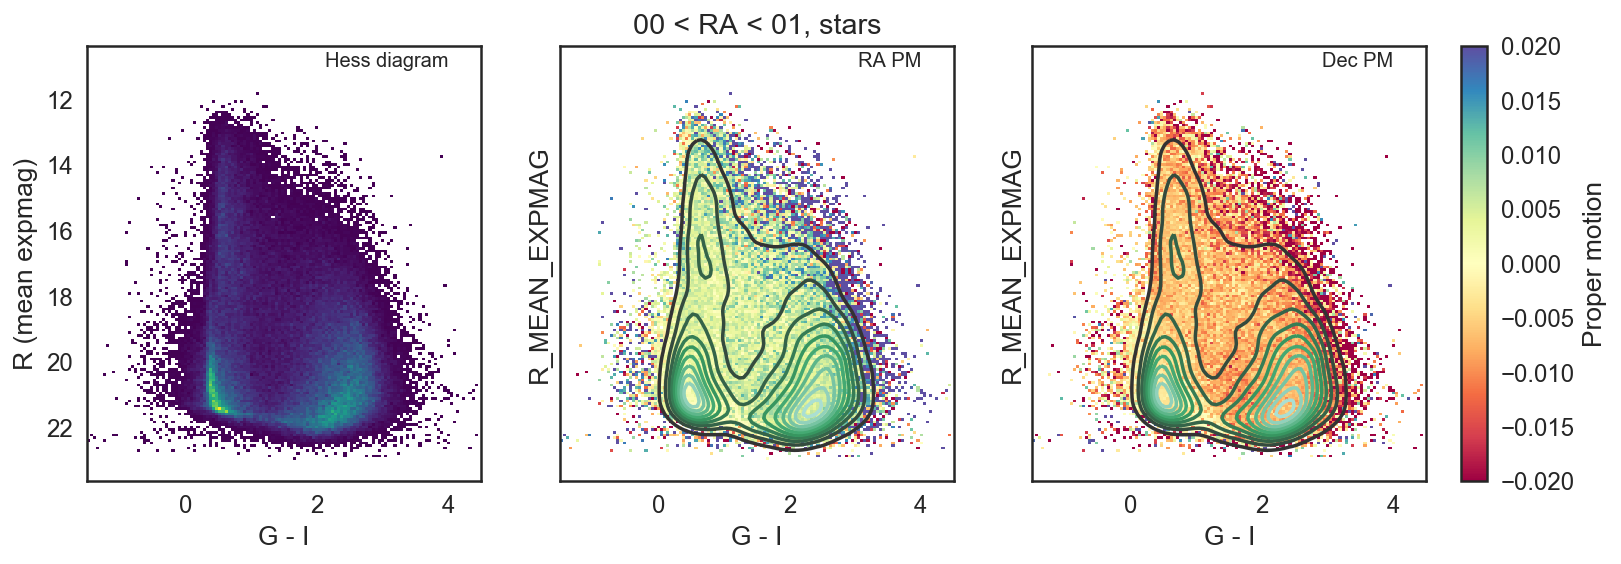

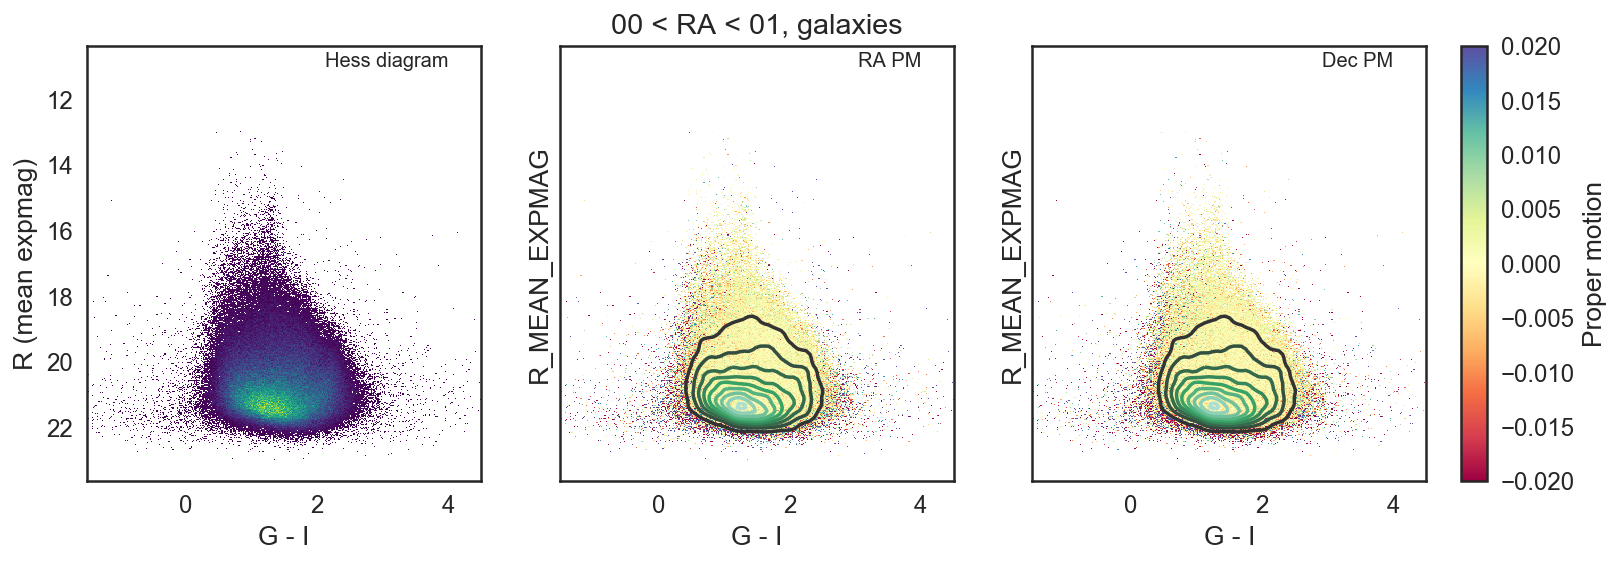

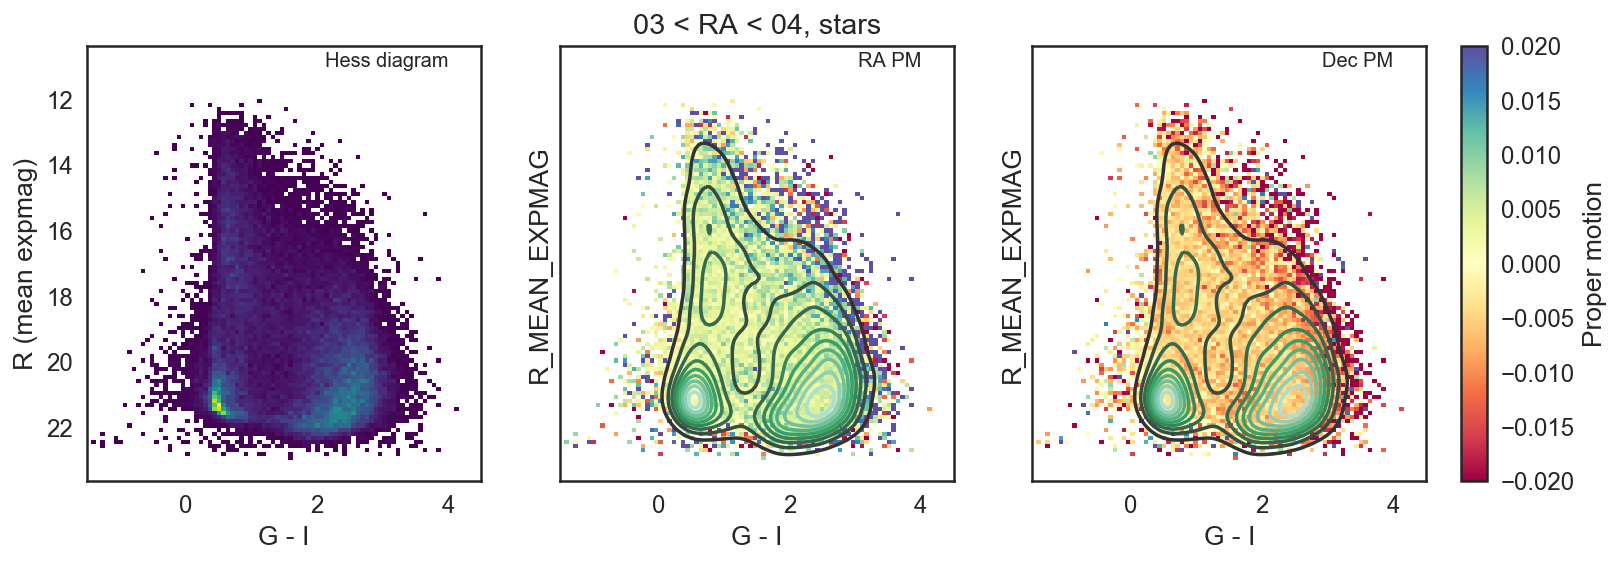

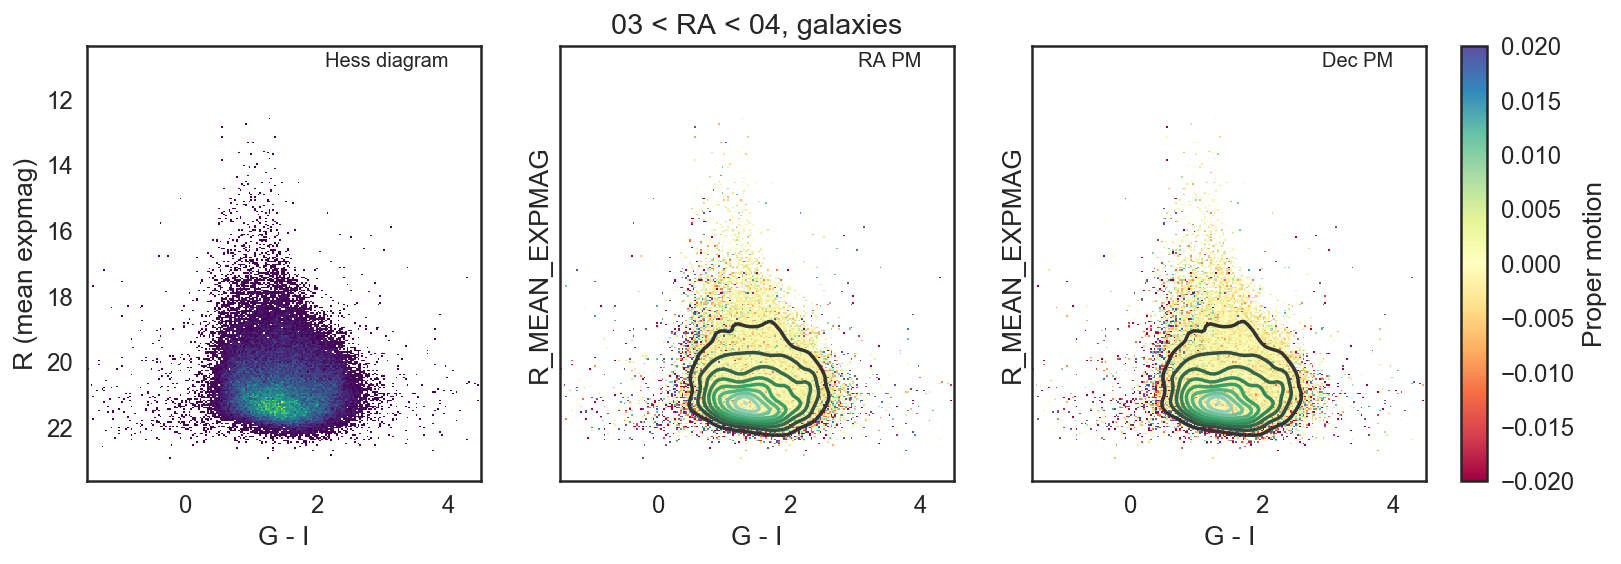

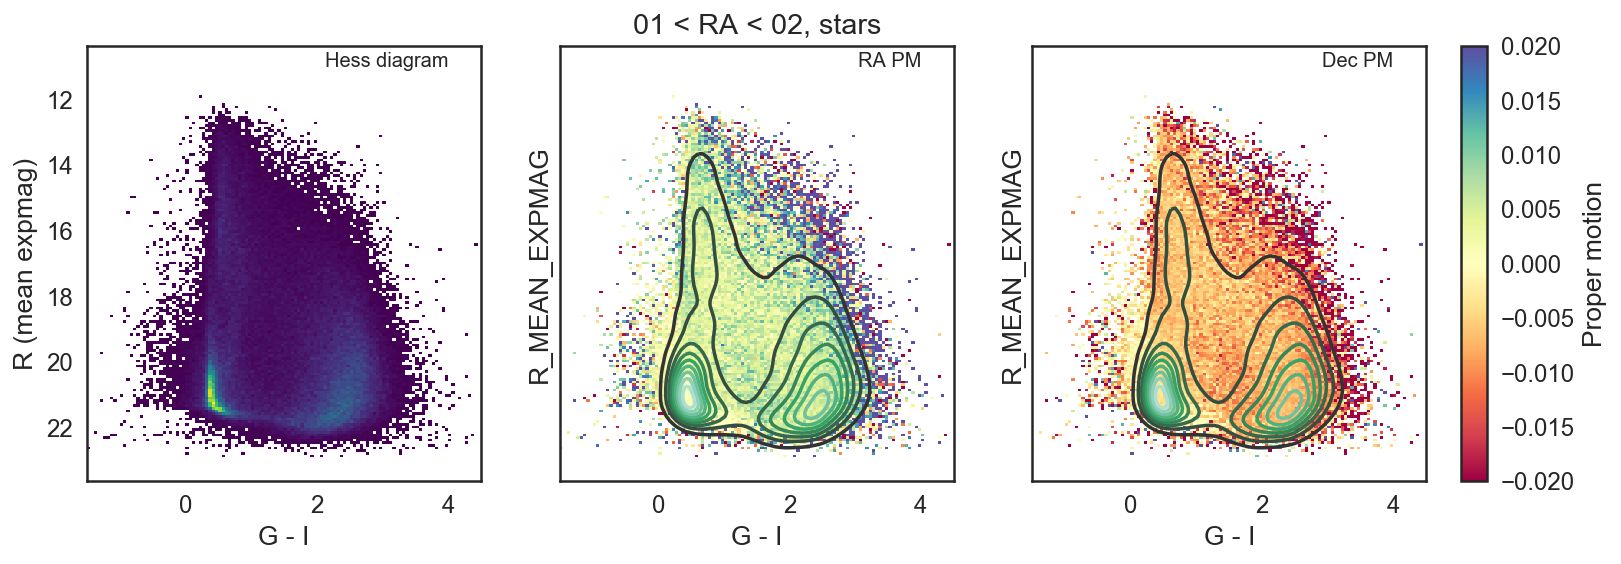

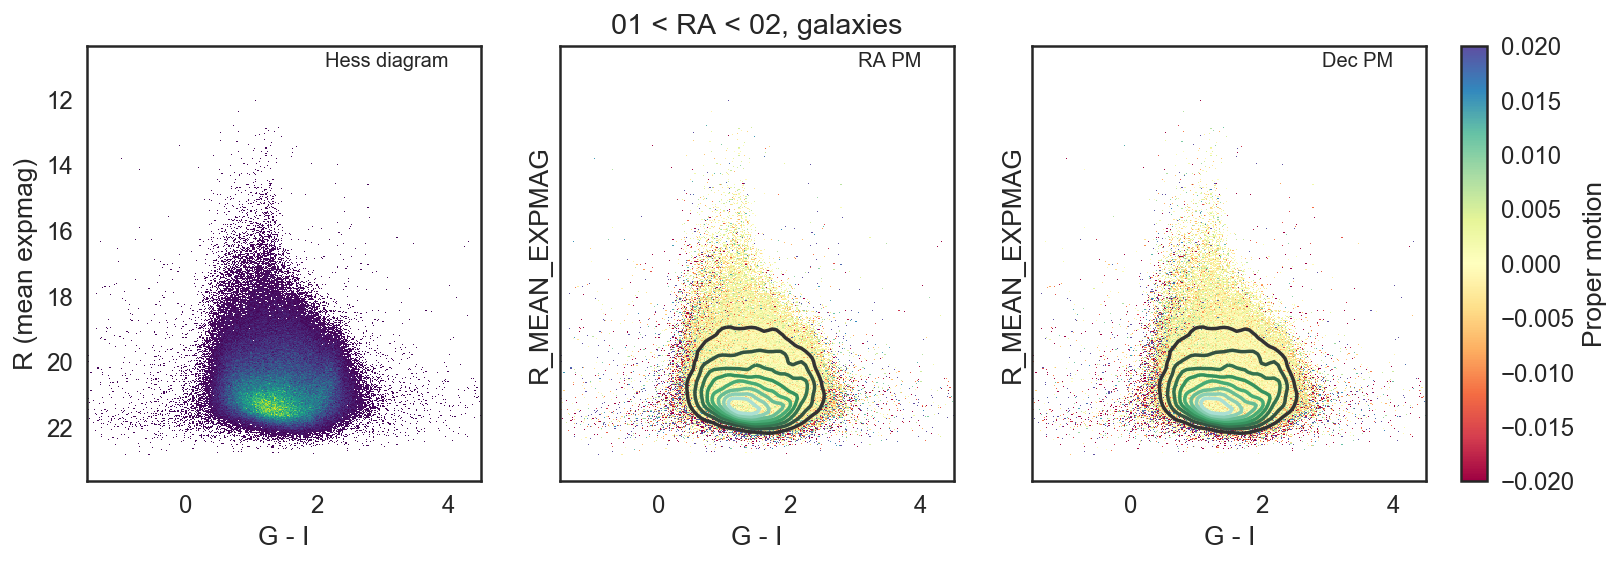

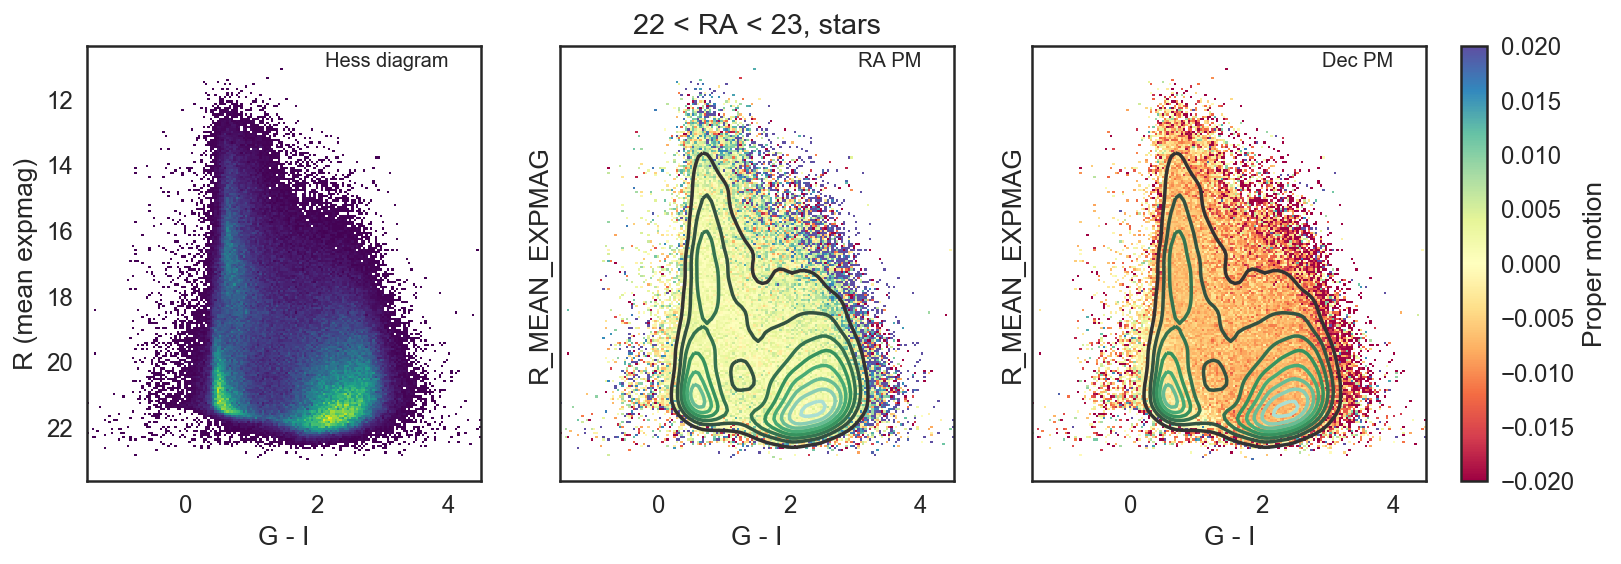

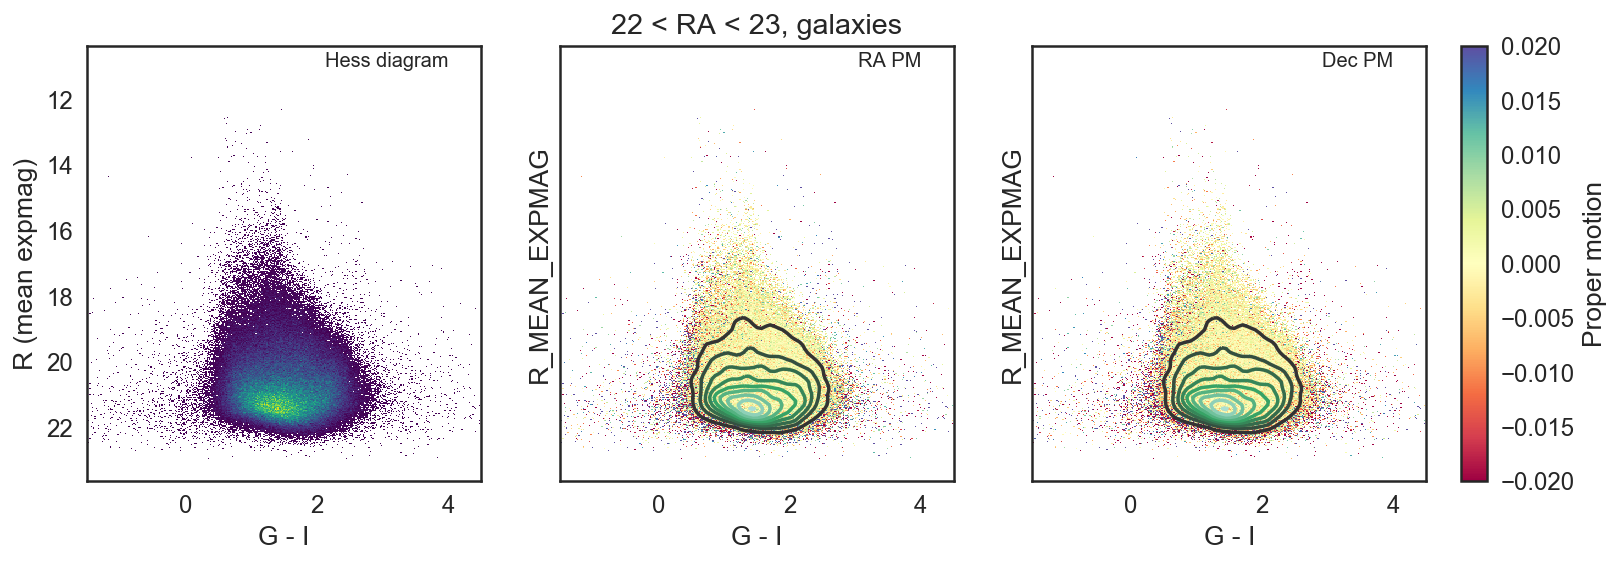

In [11]:
for hdffile in glob.glob('HLC*.hdf5'):
    ra_lim = hdffile.split('_')[1], hdffile.split('_')[3].split('.')[0]
    df_stars, df_galaxies = read_df(hdffile)
    fig, (ax1, ax2, ax3) = make_histograms(df_stars)
    ax2.set_title('{} < RA < {}, stars'.format(*ra_lim))
    fig, (ax1, ax2, ax3) = make_histograms(df_galaxies)
    ax2.set_title('{} < RA < {}, galaxies'.format(*ra_lim))

We can see that there is structure to the stellar proper motions, but none to the galaxy proper motions, as expected. Stars in our galaxy are moving in a non-random manner, whereas galaxy motions are isotropic.

## Other Plots <a id="Other"></a>

First, let's read in all the data at once and convert it to a Vaex dataset for easy plotting.

In [5]:
# vaex.open_many isn't working or I'd use that
df = dd.read_hdf('HLC*.hdf5', key='data').query(query_str +
    ' & (U_MEAN_EXPMAG > 0)').compute() # everything with valid UGRI data this time
df = df.assign(U_G_COLOR=df.U_MEAN_EXPMAG - df.G_MEAN_EXPMAG)
df = df.assign(G_R_COLOR=df.G_MEAN_EXPMAG - df.R_MEAN_EXPMAG)
ds = vaex.from_pandas(df)

### Magnitude Choice<a id="mag"></a>

First, I will justify my choice to use the EXPMAG quantity over the PSFMAG by plotting the difference between EXPMAG and PSFMAG against the mean object type for the R band.

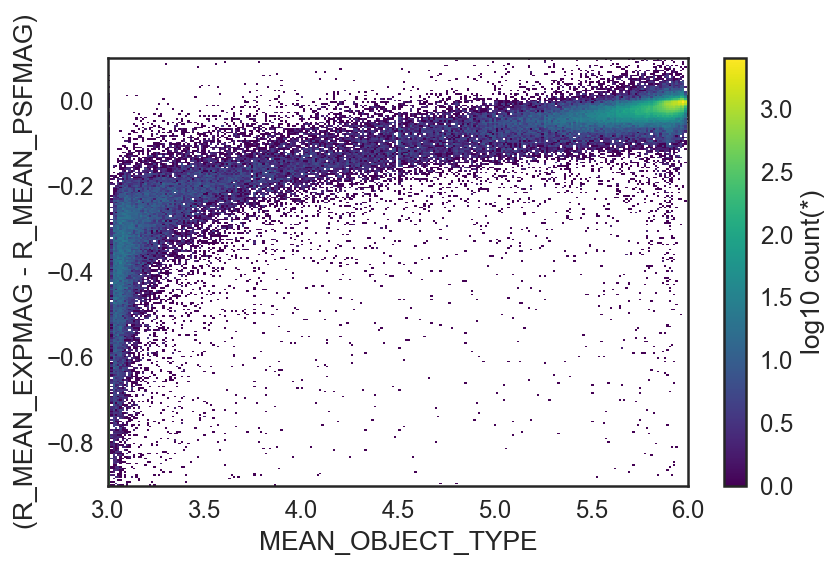

In [6]:
ds.plot(ds.MEAN_OBJECT_TYPE, ds.R_MEAN_EXPMAG - ds.R_MEAN_PSFMAG,
        f='log10', limits=[[3,6],[-0.9,0.1]], colormap='viridis')

For extended objects (object type < 5), the difference betwen PSFMAG and EXPMAG is much more significant than for point sources (object type > 5), as we might expect. As the vast majority of point sources have a magnitude difference close to zero, we are justified in using EXPMAG for all sources.

### Proper motion distributions<a id="pm"></a>
Given the apparent proper motion anisotropies for stars and the lack thereof for galaxies, I'm curious about the overall distributions of proper motions.

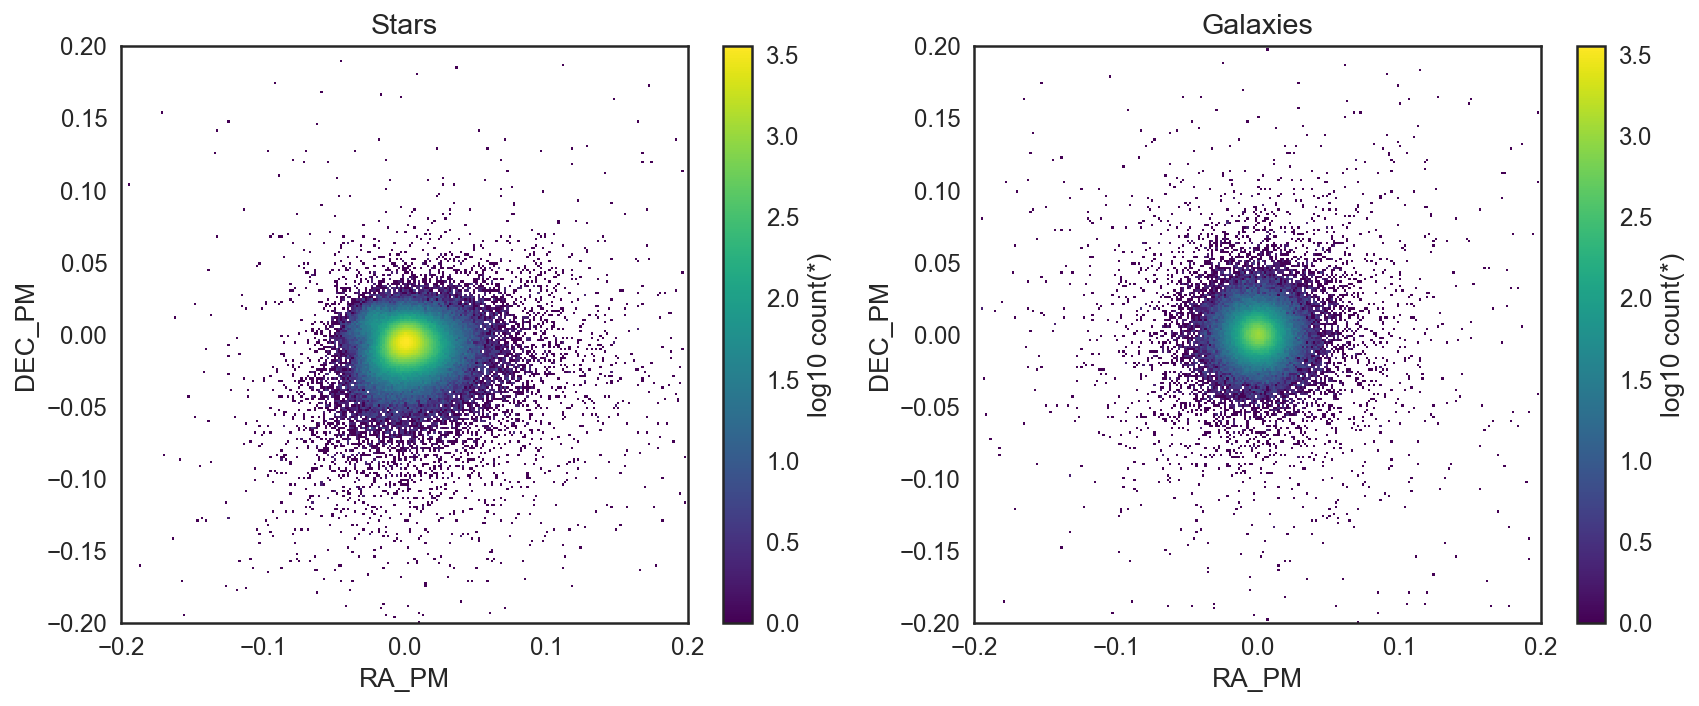

In [7]:
ds.plot(ds.RA_PM, ds.DEC_PM, f='log10', 
        colormap='viridis', visual={'column':'selection'},
        limits=[-0.2,0.2], figsize=(12,5), 
        selection=['(MEAN_OBJECT_TYPE > 5)',
                   '(MEAN_OBJECT_TYPE <= 5)'],
        selection_labels=['Stars','Galaxies'])

### Color-Color Diagrams<a id="color"></a>

Next, let's look at some U-G vs. G-R diagrams of stars and galaxies.

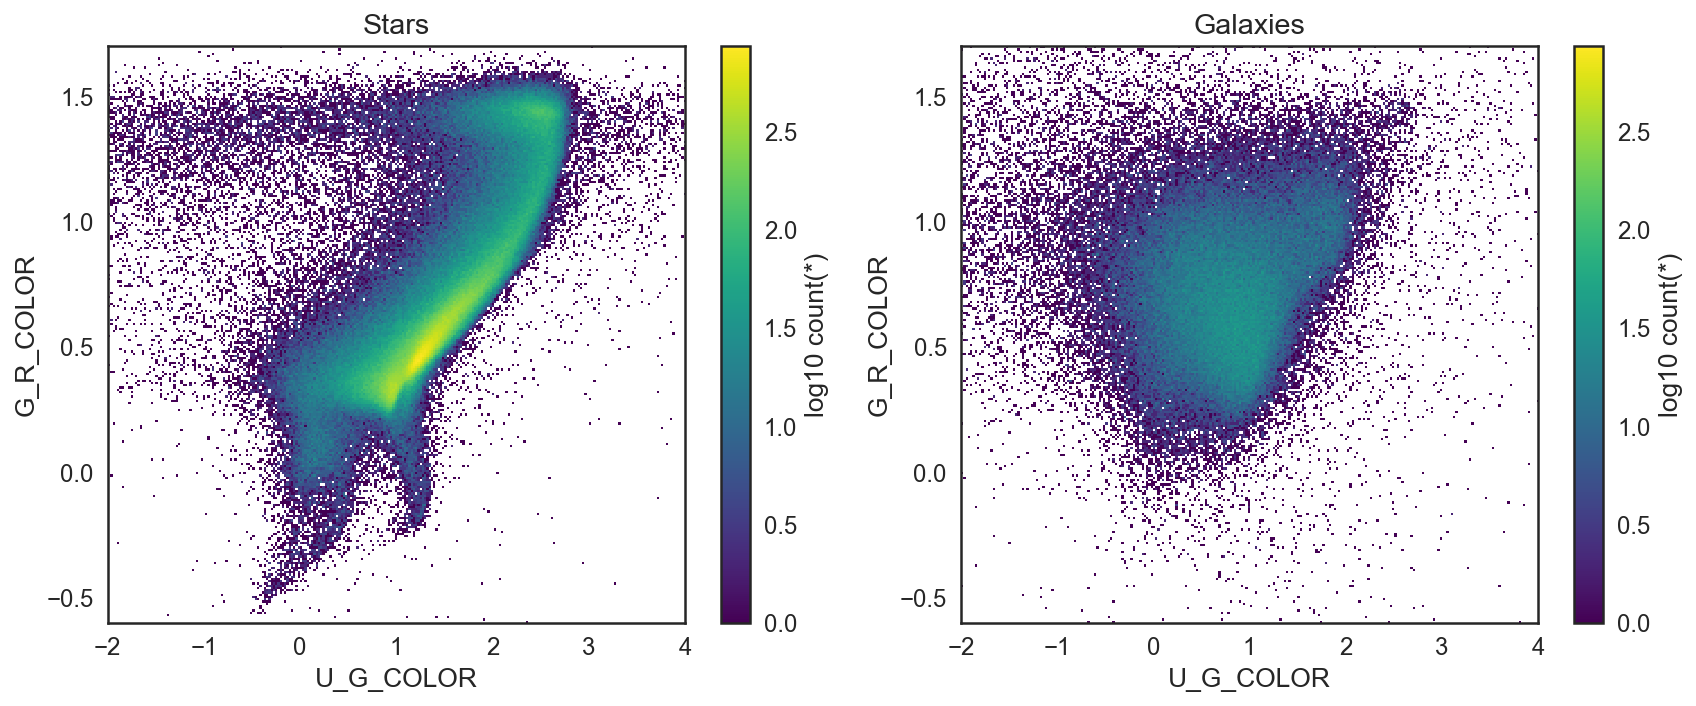

In [8]:
ds.plot(ds.U_G_COLOR, ds.G_R_COLOR, f='log10', 
        colormap='viridis', visual={'column':'selection'},
        limits=[[-2,4], [-0.6,1.7]], figsize=(12,5),
        selection=['(MEAN_OBJECT_TYPE > 5)',
                   '(MEAN_OBJECT_TYPE <= 5)'],
        selection_labels=['Stars','Galaxies'])

### Reddening Map<a id="reddening"></a>

Finally, just for fun let's plot the mean reddening over a small selection of Stripe 82. (I know median is preferable to mean, but vaex's median function is finicky.)

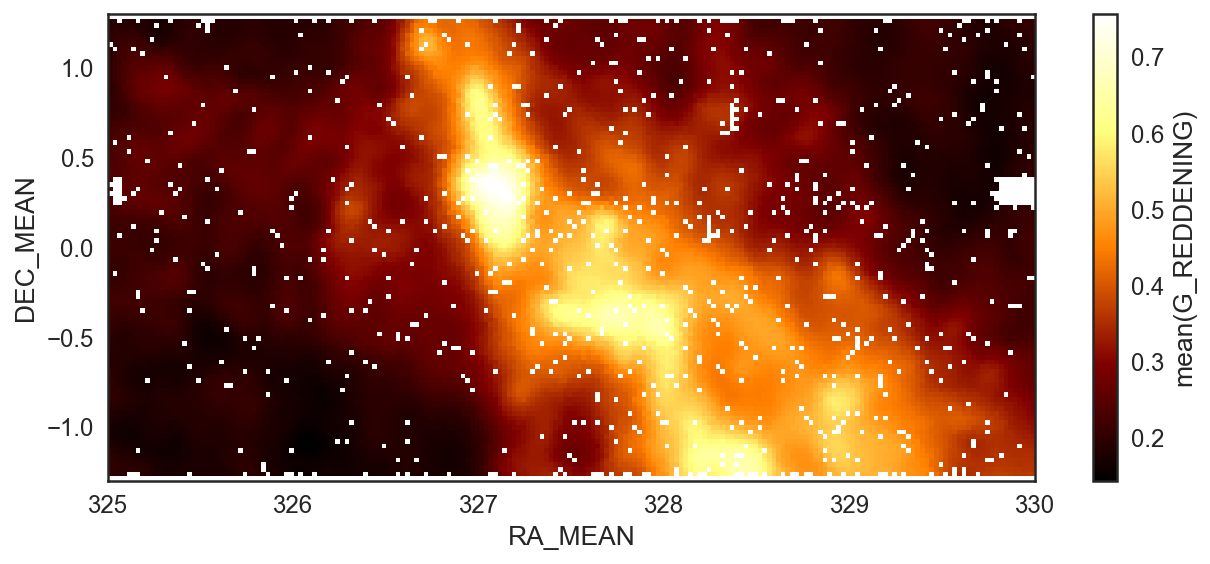

In [9]:
ds.plot(ds.RA_MEAN, ds.DEC_MEAN, what=vaex.stat.mean(ds.G_REDDENING),
        figsize=(9,4), shape=(200,100), limits=[[325,330],[-1.3,1.3]], 
        selection=['(RA_MEAN > 325) & (RA_MEAN < 330)'])

In [10]:
# 2*interquartile range / n^(1/3)